# Parse New Gene Table

**from:** Maria D. Vibranovski

Here attached is a list from Yong Zhang group based on our paper from 2010. But this is a still not published updated version that he shared with me but you can use.

If you need details about the columns, please look at https://genome.cshlp.org/content/suppl/2010/08/27/gr.107334.110.DC1/SupplementalMaterial.pdf  table 2a.

But mainly, what you need to select is the child genes with:

gene_type = D or R or DL or RL
m_type= M
note that contains "chrX-"

D and R stands for DNA-based Duplication and RNA-based duplication
L means that the assignment of the parental genes is less reliable.
M indicates that is between chromosome movement.

Hope it helps. If you need I can parse for you. please, do not hesitate to ask. But I thought you would prefer a complete list where you can look at subsets.

cheers

Maria


In [1]:
import os
import sys
from pathlib import Path
import re

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from scipy.stats.contingency import margins
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.stats import run_chisq

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-04-12 
Git hash: 8b2294f0f1fb95fa1db81581d215310271068158


In [3]:
def adjusted_residuals(observed, expected):
    resid = (observed - expected) / np.sqrt(expected)
    n = observed.sum().sum()
    rsum, csum = margins(observed)
    v = csum * rsum * (n - rsum) * (n - csum) / n**3
    return (observed - expected) / np.sqrt(v)

## Import data from Maria

## FBgn sanitizer

I don't know where these FBgns are from, so I need to sanitize them to my current annotation.

In [4]:
assembly = nbconfig.assembly
tag = nbconfig.tag
pth = Path(os.environ['REFERENCES_DIR'], f'{assembly}/{tag}/fb_annotation/{assembly}_{tag}.fb_annotation')

# Create an FBgn 
mapper = {}

for record in pd.read_csv(pth, sep='\t').to_records():
    mapper[record.primary_FBgn] = record.primary_FBgn
    
    try:
        for g in record.secondary_FBgn.split(','):
            mapper[g] = record.primary_FBgn
    except AttributeError:
        pass

In [5]:
autosomes = ['chr2L', 'chr2R', 'chr3L', 'chr3R']

In [6]:
movement = (
    pd.read_excel('../data/external/maria/dm6_ver78_genetype.new.xlsx')
    .query('gene_type == ["D", "R", "Dl", "Rl"] and m_type == "M"')
    .assign(child_chrom = lambda df: df.note.str.extract('(chr.*?)-'))
    .assign(parent_chrom = lambda df: df.note.str.extract('-(chr.*?)[:;]'))
    .assign(FBgn = lambda df: df.child_id.map(mapper))
    .assign(parent_FBgn = lambda df: df.parent_id.map(mapper))
    .drop(['child_id', 'parent_id', 'note', 'm_type'], axis=1)
    .dropna()
    .set_index('FBgn')
    .assign(moved_x_to_a = lambda df: (df.parent_chrom == 'chrX') & df.child_chrom.isin(autosomes))
    .assign(moved_a_to_a = lambda df: df.parent_chrom.isin(autosomes) & df.child_chrom.isin(autosomes))
    .assign(moved_a_to_x = lambda df: df.parent_chrom.isin(autosomes) & (df.child_chrom == 'chrX'))
    .query('moved_x_to_a | moved_a_to_a | moved_a_to_x')
)

movement.head()

,gene_type,child_chrom,parent_chrom,parent_FBgn,moved_x_to_a,moved_a_to_a,moved_a_to_x
FBgn,,,,,,,
FBgn0000246,Dl,chr3R,chrX,FBgn0002873,True,False,False
FBgn0002562,D,chrX,chr2L,FBgn0002563,False,False,True
FBgn0003060,D,chr3R,chr2L,FBgn0032282,False,True,False
FBgn0003086,Dl,chrX,chr3L,FBgn0036393,False,False,True
FBgn0003357,R,chr3R,chr3L,FBgn0250815,False,True,False


In [7]:
germ_comp = (
    pd.read_csv('../output/scrnaseq-wf/germcell_deg/gonia_vs_mid.tsv', sep='\t')
    .assign(FBgn = lambda df: df.primary_FBgn)
    .assign(SP = lambda df: df.avg_logFC > 0)
    .assign(CYTE = lambda df: df.avg_logFC < 0)
    .set_index('FBgn')
    .loc[:, ['SP', 'CYTE']]
    .idxmax(axis=1)
    .rename('bias_gonia_vs_cyte')
)

In [8]:
df = (
    movement
    .join(germ_comp.rename('bias_gonia_vs_cyte_child'), how='left')
    .join(germ_comp.rename('bias_gonia_vs_cyte_parent'), on='parent_FBgn', how='left')
    .fillna('None')
)

In [9]:
df = (
    movement
    .join(germ_comp.rename('bias_gonia_vs_cyte_child'), how='left')
    .fillna(dict(moved_x_to_a=False, moved_a_to_a=False, moved_a_to_x=False, bias_gonia_vs_cyte_child='No Bias'))
    .join(germ_comp.rename('bias_gonia_vs_cyte_parent'), on='parent_FBgn', how='left')
    .assign(movement=lambda df: df[['moved_a_to_a', 'moved_a_to_x', 'moved_x_to_a']].idxmax(axis=1).replace({'moved_x_to_a': 'X→A', 'moved_a_to_a': 'A→A', 'moved_a_to_x': 'A→X'}))
)

In [10]:
ct = pd.crosstab(df.moved_x_to_a, df.bias_gonia_vs_cyte_child)
run_chisq(ct)

𝛘^2: 18.5857, p-value: 0.0001, df: 2


bias_gonia_vs_cyte_child          CYTE   No Bias       SP
moved_x_to_a type                                        
False        observed          63.0000  109.0000   5.0000
             expected          67.1878   98.2531  11.5592
             residual          -4.1878   10.7469  -6.5592
             adj std residual  -1.2312    3.0854  -3.7877
             X^2                0.2610    1.1755   3.7220
             fdr q-value        0.1870    0.0051   0.0009
             flag_sig           0.0000    1.0000   1.0000
True         observed          30.0000   27.0000  11.0000
             expected          25.8122   37.7469   4.4408
             residual           4.1878  -10.7469   6.5592
             adj std residual   1.2312   -3.0854   3.7877
             X^2                0.6794    3.0598   9.6881
             fdr q-value        0.1870    0.0051   0.0009
             flag_sig           0.0000    1.0000   1.0000

In [11]:
tpm = (
    pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
    .assign(cluster = lambda df: df.cluster.map(nbconfig.short_cluster_annot))
    .pivot_table(index='FBgn', columns='cluster', values='TPM')
    .loc[:, ['SP', 'M1º']]
)

In [12]:
df = (
    df
    .join(tpm['SP'].rename('SP_child'), how='left')
    .join(tpm['M1º'].rename('M1_child'), how='left')
    .join(tpm['SP'].rename('SP_parent'), on='parent_FBgn', how='left')
    .join(tpm['M1º'].rename('M1_parent'), on='parent_FBgn', how='left')
    .fillna(0)
)

In [13]:
df.head()

,gene_type,child_chrom,parent_chrom,parent_FBgn,moved_x_to_a,moved_a_to_a,moved_a_to_x,bias_gonia_vs_cyte_child,bias_gonia_vs_cyte_parent,movement,SP_child,M1_child,SP_parent,M1_parent
FBgn,,,,,,,,,,,,,,
FBgn0000246,Dl,chr3R,chrX,FBgn0002873,True,False,False,No Bias,0,X→A,74.507506,40.811514,0.652152,1.751364
FBgn0002562,D,chrX,chr2L,FBgn0002563,False,False,True,No Bias,0,A→X,0.023132,0.061855,0.144521,0.137125
FBgn0003060,D,chr3R,chr2L,FBgn0032282,False,True,False,No Bias,0,A→A,0.021381,0.000000,0.075548,0.126258
FBgn0003086,Dl,chrX,chr3L,FBgn0036393,False,False,True,No Bias,0,A→X,0.000000,0.000000,0.000000,0.057476
FBgn0003357,R,chr3R,chr3L,FBgn0250815,False,True,False,No Bias,0,A→A,0.000000,0.000000,0.000000,0.000000


[Text(0,0.5,'M1° Normalized Expression'), Text(0.5,1,'Child Gene Expression')]

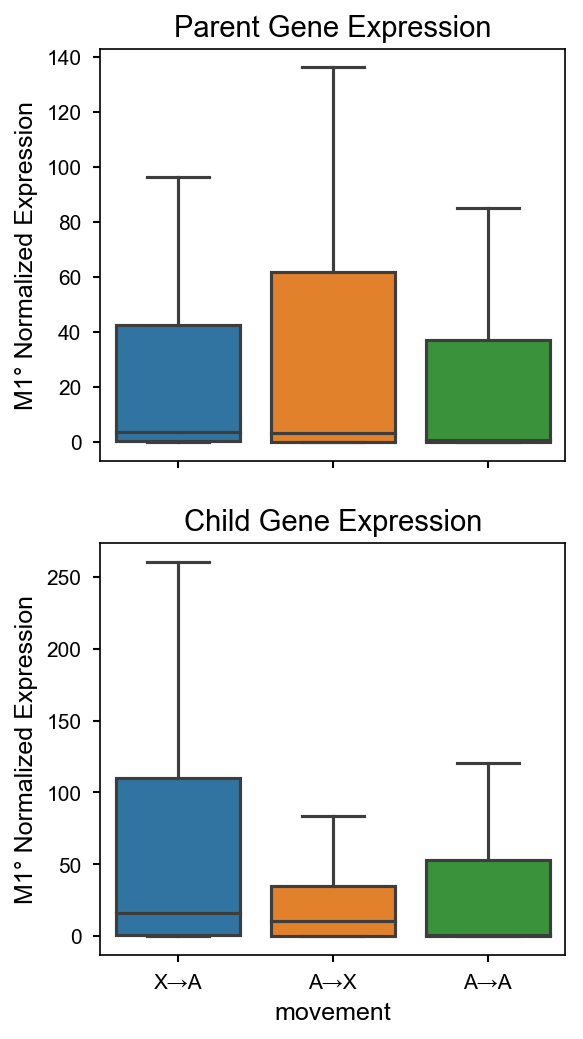

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=plt.figaspect(2), sharex=True)
sns.boxplot('movement', 'M1_parent', data=df, showfliers=False, ax=ax1)
ax1.set(ylabel='M1° Normalized Expression', xlabel='', title='Parent Gene Expression')

sns.boxplot('movement', 'M1_child', data=df, showfliers=False, ax=ax2)
ax2.set(ylabel='M1° Normalized Expression', title='Child Gene Expression')